In [ ]:
from typing import Optional
def execute_chart_code_safely(code: str, llm_output: str, chart_format: str = "png", dpi: int = 100) -> tuple[bytes, bool, Optional[str]]:
    """
    Execute generated chart code in a restricted environment.
    Returns: (chart_bytes, success, error_message)
    """

    # Create restricted globals - only allow safe operations
    safe_globals = {
        '__builtins__': {
            'len': len,
            'range': range,
            'enumerate': enumerate,
            'zip': zip,
            'str': str,
            'int': int,
            'float': float,
            'list': list,
            'dict': dict,
            'tuple': tuple,
            'min': min,
            'max': max,
            'sum': sum,
            'abs': abs,
            'round': round,
            'print': print,
            'format': format,  
            '__import__': __import__,  
            'isinstance': isinstance,
            'hasattr': hasattr,
            'getattr': getattr,
            'setattr': setattr,
            'type': type,
            'bool': bool,
            'sorted': sorted,
            'reversed': reversed,
            'all': all,
            'any': any,
            'ValueError': ValueError,
            'TypeError': TypeError,
            'KeyError': KeyError,
            'IndexError': IndexError,
            'AttributeError': AttributeError,
        },
        'pd': pd,
        'plt': plt,
        'np': np,
        'sns': sns,
        'io': io,
        're': re,
        'json': json,
        'llm_output': llm_output,  # Pass the actual LLM output as a variable
        'chart_format': chart_format,
        'dpi': dpi,
    }
    
    # Use the same dict for both globals and locals so functions can see each other
    # This allows helper functions defined in the code to be accessible to each other
    safe_locals = safe_globals.copy()
    
    try:
        # Clean up code - remove markdown code blocks if present
        # Remove ```python at the start
        code = re.sub(r'^```python\s*', '', code, flags=re.MULTILINE)
        # Remove ``` at the end
        code = re.sub(r'```\s*$', '', code, flags=re.MULTILINE)
        # Remove any remaining ``` markers
        code = re.sub(r'```', '', code)
        code = code.strip()
        
        # Execute the code - using same dict for globals and locals so functions can see each other
        exec(code, safe_globals, safe_locals)
        
        # Get the chart buffer from locals (or globals if not in locals)
        if 'chart_buffer' not in safe_locals and 'chart_buffer' not in safe_globals:
            return None, False, "Code did not create 'chart_buffer' variable"
        
        chart_buffer = safe_locals.get('chart_buffer') or safe_globals.get('chart_buffer')
        
        if not isinstance(chart_buffer, io.BytesIO):
            return None, False, "chart_buffer is not a BytesIO object"
        
        chart_bytes = chart_buffer.getvalue()
        
        if len(chart_bytes) == 0:
            return None, False, "Chart buffer is empty"
        
        return chart_bytes, True, None
        
    except Exception as e:
        error_msg = f"Code execution error: {str(e)}"
        print(error_msg)
        import traceback
        print(traceback.format_exc())
        return None, False, error_msg

# LOOKS GOOD

In [ ]:
TABLE_SPLIT_PROMPT = """ ### ROLE
You are a Financial Data Architect for a Private Equity firm. Your task is to extract and restructure data from complex markdown financial statements into professional "Plot-Ready" instructions. Accuracy is paramount.

### OBJECTIVE
Analyze the provided markdown file. Decompose tables into logical, simplified datasets for plotting. A single table section can result in multiple charts.

### NO ROUNDING POLICY
STRICT NUMERIC ACCURACY: Ensure every single digit is preserved. Do NOT round or abbreviate. E.g., '112,580,575' must be '112580575.0'.

### ALLOWED PLOT TYPES
1. bar_chart: Standard vertical bars. Best for few categories with short names.
2. horizontal_bar_chart: Best for many categories OR categories with long descriptive names (e.g., balance sheet line items).
3. stacked_bar_chart: Best for showing composition across different entities or years.
4. pie_chart: ONLY for simple compositions (parts of a whole) with VERY FEW categories.

### EXTRACTION & ROBUSTNESS RULES
1. **Numeric Integrity**: Extract raw numbers. Remove commas, currency symbols, text units. Handle `(value)` or `-value` as negatives. Treat `-` or empty as `0.0`.
2. **Entity Separation**: Create dedicated charts comparing entities/years.
3. **Data Matching**: Ensure labels match data point counts.
4. **Exclusions**: Never plot "Total" rows alongside their components.
5. **NEGATIVE VALUE SAFETY**: Financial metrics that can be negative (Net Income, Cash Flow) must NEVER be a 'pie_chart' or 'stacked_bar_chart'. Use 'bar_chart' or 'horizontal_bar_chart'.

### CRITICAL VISUALIZATION RULES (PE STANDARD)
1. **PIE CHART RESTRICTION**: Do NOT use 'pie_chart' if there are more than 5 categories. If there are > 5 components, you MUST use 'horizontal_bar_chart' or 'bar_chart' so the labels are readable.
2. **LONG LABELS**: If the category names are long financial descriptions (e.g., "Investments in associates and joint ventures"), prefer 'horizontal_bar_chart' over standard 'bar_chart'.

### OUTPUT FORMAT
Return ONLY a valid JSON array. No markdown blocks.
"""

PLOT_GENERATION_PROMPT = """ ### ROLE
You are a Senior Python Developer specializing in high-end financial data visualization for Private Equity. Your task is to convert a JSON object into executable Python code using Pandas, Matplotlib, and Seaborn.

### INPUT DATA
The 'llm_output' variable is provided as a JSON string.

### PE VISUAL STANDARDS
- **Style**: Clean, minimal, professional. Focus on data ink.
- **Colors (Dynamic Dark Pastel)**: For n-years of data, use a professional dark pastel sequence.
  # Primary Dark Pastel Sequence: ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F', '#EDC948', '#9C755F', '#BAB0AC']
- **Background**: sns.set_theme(style="whitegrid", rc={"axes.facecolor": "#ffffff", "grid.color": "#f0f0f0"}).

### TASK: GENERATE EXECUTABLE CODE

STEP 1: Setup & Dependencies (CRITICAL)
- You MUST include `import pandas as pd`, `import matplotlib.pyplot as plt`, `import seaborn as sns`, `import numpy as np`, `import io`, `import json`, `import math`, `import matplotlib.ticker as ticker`, `import traceback`, and `import builtins` at the absolute top.
- **Helper Scoping (MANDATORY)**: Define `def format_val(x, pos=None):` at the absolute top level. Inside, use `abs(x)` to determine thresholds for B (1e9), M (1e6), and K (1e3).
- **Dynamic Color Logic**: Define `dark_pastels = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F', '#EDC948', '#9C755F', '#BAB0AC']` at the top level.

STEP 2: Generate Visualizations
- Load data: `charts_list = json.loads(llm_output)`.
- Create figure: `fig, axes = plt.subplots(nrows=math.ceil(len(charts_list)/2), ncols=2 if len(charts_list)>1 else 1, figsize=(24, 9 * math.ceil(len(charts_list)/2)))`.
- Ensure `axes_flat = axes.flatten() if len(charts_list) > 1 else [axes]`.

- **CHART LOGIC & SCOPING (CRITICAL)**: 
    - Inside your loop, define your DataFrame: `df = pd.DataFrame(...)`.
    - **Dynamic Color Assignment**: Create a color list based on the number of columns: `colors = dark_pastels[:len(df.columns)]`. If len(df.columns) > len(dark_pastels), use `sns.color_palette("husl", len(df.columns))`.
    - A. **'bar_chart' / 'stacked_bar'**: Use `df.plot(kind='bar', ax=ax, width=0.8, color=colors)`. 
    - B. **'horizontal_bar_chart'**: Use `df.plot(kind='barh', ax=ax, width=0.8, color=colors)`. Call `ax.invert_yaxis()`.
    - C. **'pie_chart'**: If negatives exist, convert to 'barh'. Use `colors=colors, autopct='%1.1f%%', pctdistance=0.85`.

- **LEGEND & LABEL FIXES (CRITICAL)**:
    - **Legend Overlap Fix**: Always move legend outside the plot area: `ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False, fontsize=10)`.
    - **Bar Label Fix**: For labels, use `ax.bar_label(c, fmt=format_val, padding=3, fontsize=8, fontweight='bold')`. You MUST pass `format_val` directly (no lambda).
    - **Tick Alignment Fix**: For rotating labels, use `plt.setp(ax.get_xticklabels(), rotation=45, ha='right')`.

- **FINAL STYLING**:
    - `sns.despine(ax=ax, left=True, bottom=True)`.
    - `ax.set_title(chart.get('plot_title', 'Chart'), fontweight='bold', loc='left', pad=30, fontsize=15)`.
    - Apply `ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_val))` or `ax.yaxis` depending on orientation.
    - Use `plt.tight_layout(rect=[0, 0.03, 0.85, 0.95])` to protect legend space.
    - Turn off unused axes: `for j in range(len(charts_list), len(axes_flat)): axes_flat[j].axis('off')`.

### CRITICAL EXECUTION REQUIREMENTS
1. **NO WRAPPING**: Execute all logic at the root level.
2. **STRICT SCOPE**: Do NOT use `locals()` or `globals()`.
3. **INTERNAL ERROR HANDLING**: Wrap the core loop in `try: ... except builtins.Exception as e: print(traceback.format_exc())`. NEVER use a `logger` variable.
4. **MANDATORY SAVING**: The code MUST end with these exact lines:
   chart_buffer = io.BytesIO()
   plt.savefig(chart_buffer, format='png', dpi=140, bbox_inches='tight')
   plt.close()

### OUTPUT FORMAT
Return ONLY the Python code. No markdown blocks.
"""

[INFO] Splitting markdown into sections...
[INFO] Extracting data from 1 sections...
[INFO] Generating charts for section: 3. Benchmarking Table (FY2024-2025)
[SUCCESS] Saved: outputs/section_charts/section_1_3_Benchmarking_Table_FY2024_2025_.png


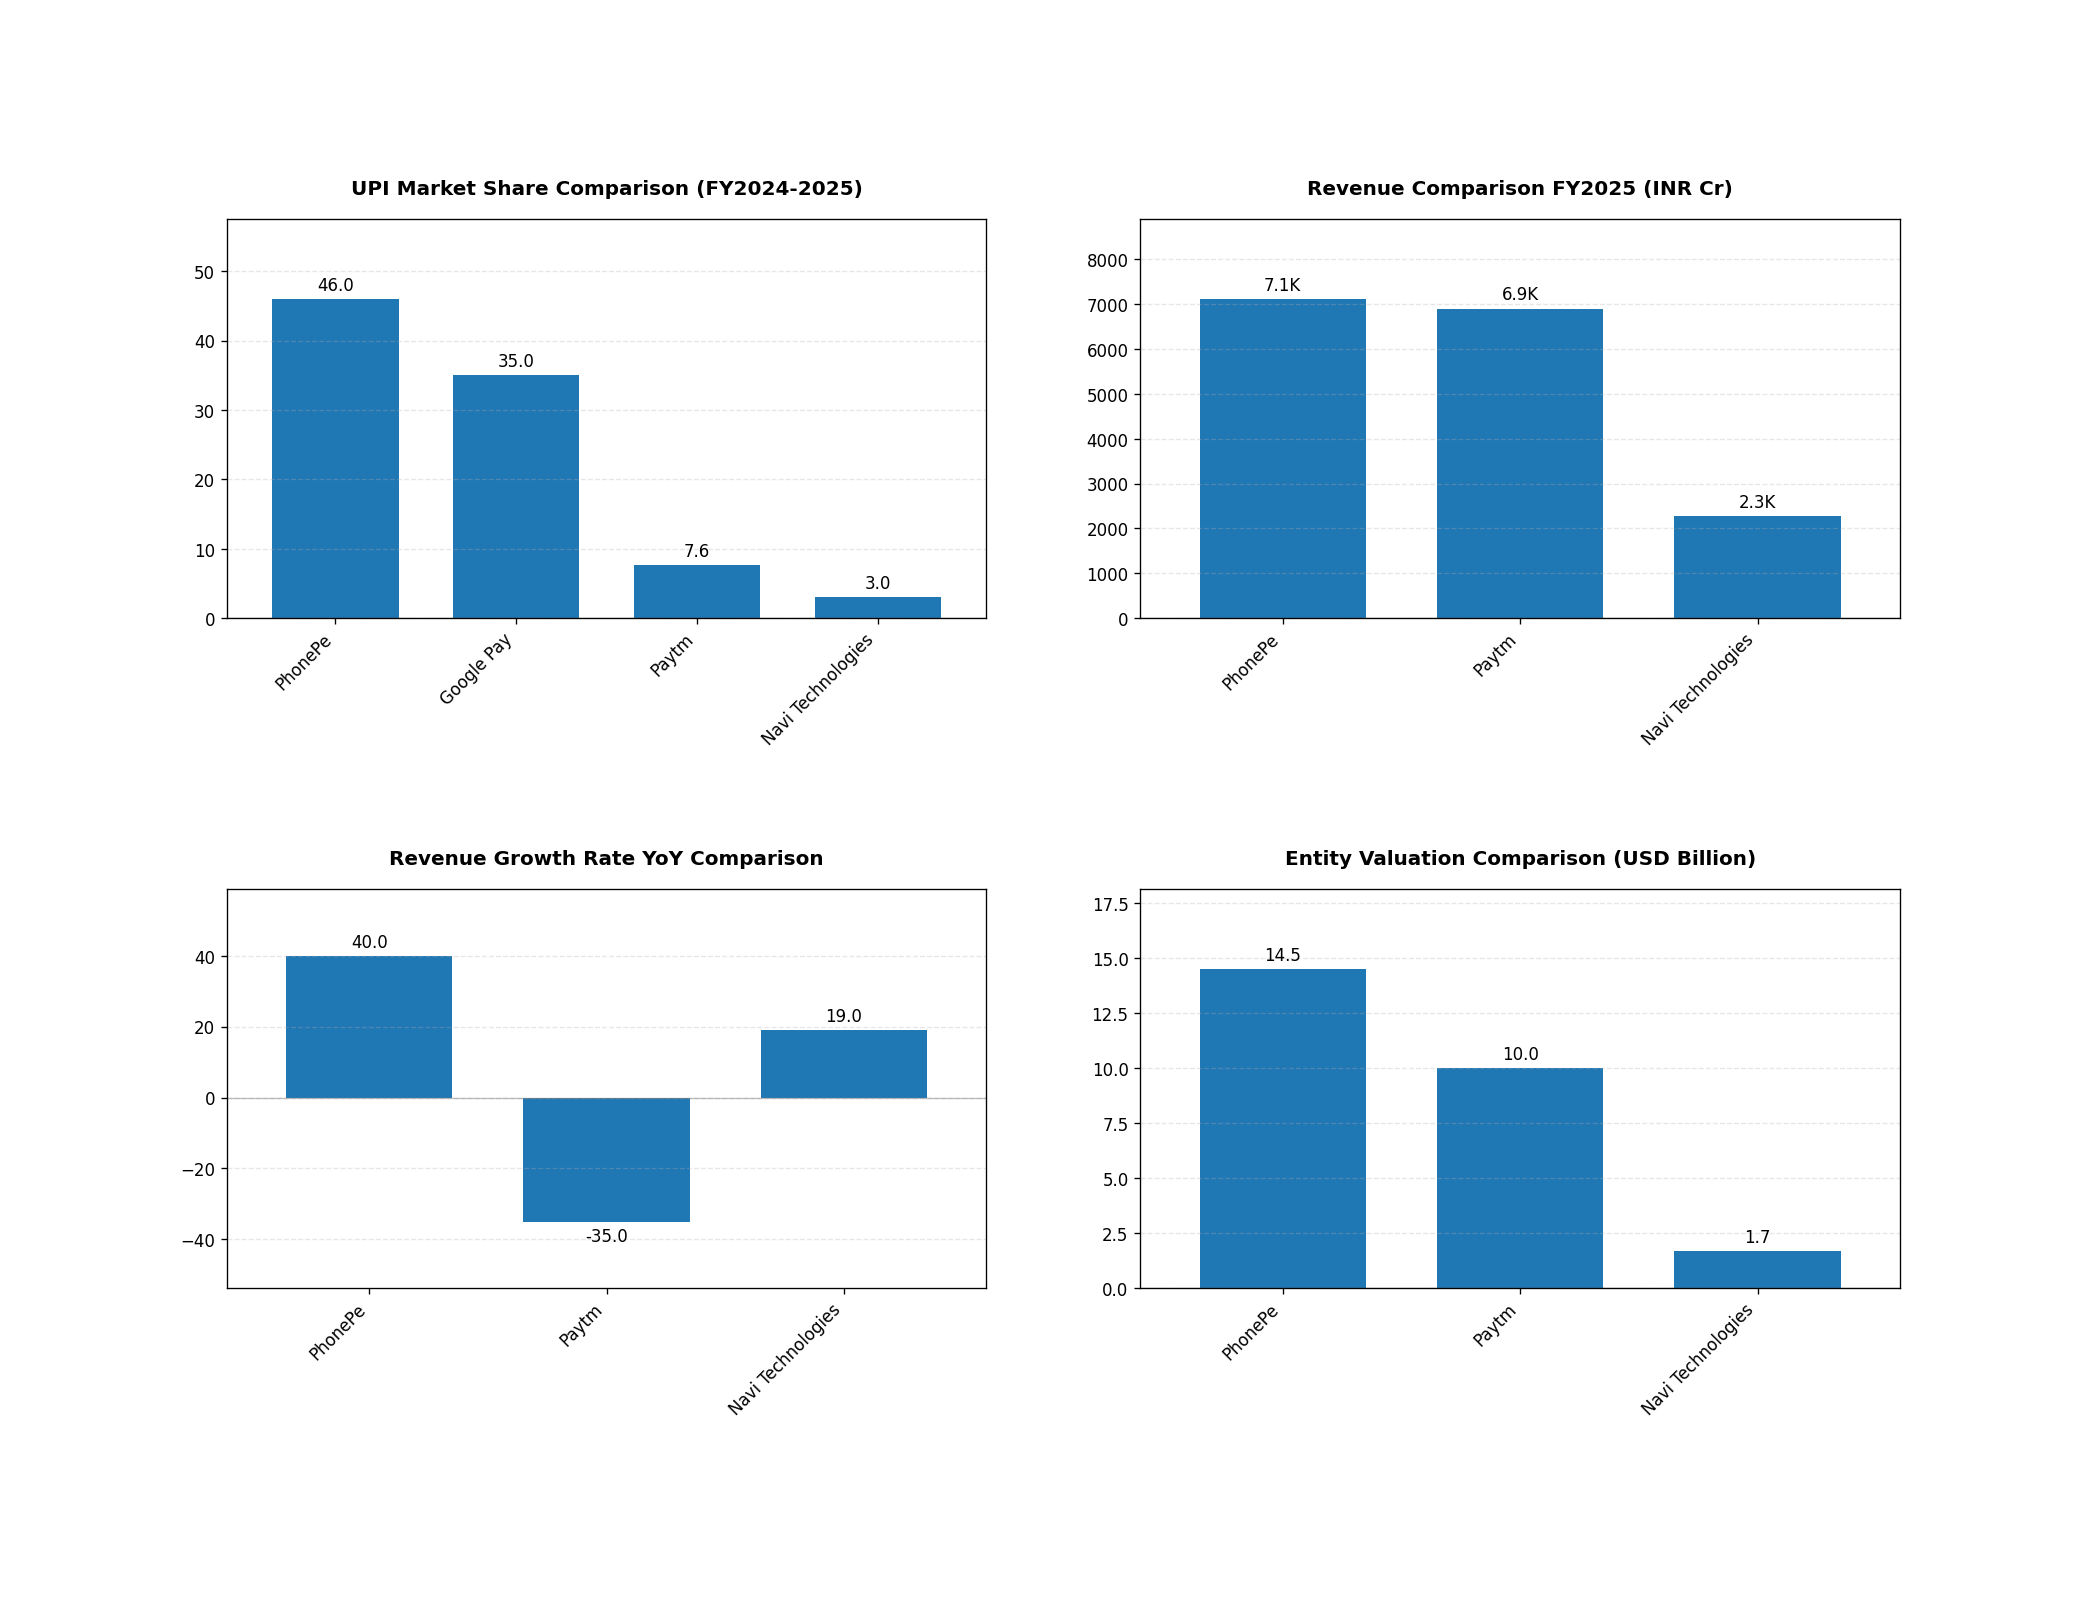

'outputs/section_charts'

In [ ]:
import io, os, re, json, asyncio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display, Image
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_text_splitters import MarkdownHeaderTextSplitter
from dotenv import load_dotenv

load_dotenv()

async def generate_financial_statements_dashboard(
    md_content: str,
    output_dir: str = "outputs/section_charts"
):
    # --- LLM Configuration ---
    flash_llm = ChatGoogleGenerativeAI(
        model="gemini-3-flash-preview",
        temperature=0.7,
        api_key=os.getenv("GOOGLE_API_KEY"),
        thinking_level="low"
    )

    pro_llm = ChatGoogleGenerativeAI(
        model="gemini-3-pro-preview",
        temperature=0.7,
        api_key=os.getenv("GOOGLE_API_KEY"),
        thinking_level="low"
    )

    # --- Helper: String Extraction ---
    def get_raw_text(response):
        content = response.content
        if isinstance(content, list):
            return "".join([part.get("text", "") if isinstance(part, dict) else str(part) for part in content]).strip()
        return str(content).strip()

    # --- Splitting Logic ---
    print("[INFO] Splitting markdown into sections...")
    splitter = MarkdownHeaderTextSplitter(headers_to_split_on=[("###", "Header 1")], strip_headers=False)
    sections = splitter.split_text(md_content)

    # --- Step 1: Parallel Data Extraction (Architect) ---
    async def extract_data(doc):
        prompt = f"{TABLE_SPLIT_PROMPT}\n\nINPUT_TEXT:\n{doc.page_content}"
        res = await flash_llm.ainvoke(prompt)
        text = get_raw_text(res)
        text = re.sub(r'^```json\s*|```$', '', text, flags=re.MULTILINE).strip()
        try:
            return {"header": doc.metadata.get("Header 1", "Chart"), "data": json.loads(text)}
        except:
            return {"header": doc.metadata.get("Header 1", "Chart"), "data": []}

    print(f"[INFO] Extracting data from {len(sections)} sections...")
    extracted_data_list = await asyncio.gather(*(extract_data(s) for s in sections))

    # --- Step 2: Sequential/Parallel Code Generation & Execution (Coder) ---
    os.makedirs(output_dir, exist_ok=True)

    for i, section in enumerate(extracted_data_list):
        if not section["data"]:
            continue
            
        print(f"[INFO] Generating charts for section: {section['header']}")
        raw_json = json.dumps(section["data"])
        
        # Call Coder LLM for this specific section
        coder_prompt = f"{PLOT_GENERATION_PROMPT}\n\nJSON_DATA:\n{raw_json}"
        coder_res = await pro_llm.ainvoke(coder_prompt)
        code = get_raw_text(coder_res)
        code = re.sub(r'^```python\s*|```$', '', code, flags=re.MULTILINE).strip()

        # Execute code to get buffer
        chart_bytes, success, error_msg = execute_chart_code_safely(
            code=code,
            llm_output=raw_json, 
            chart_format="png",
            dpi=120
        )

        if success:
            filename = f"section_{i+1}_" + re.sub(r'\W+', '_', section["header"])[:50] + ".png"
            file_path = os.path.join(output_dir, filename)
            with open(file_path, "wb") as f:
                f.write(chart_bytes)
            print(f"[SUCCESS] Saved: {file_path}")
            display(Image(data=chart_bytes))
        else:
            print(f"[ERROR] Section {section['header']} failed: {error_msg}")

    return output_dir

# Usage
with open("md_files/phonepe.md", "r", encoding="utf-8") as f:
    content = f.read()
await generate_financial_statements_dashboard(content)